In [1]:
from numpy import array,sum,histogram,exp,subtract
from math import tan,sin,cos,pi,sqrt,atan,atan2
from scipy import optimize
import sys
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import pandas as pd

In [2]:
beam_size = "(0.,0.)mm"
electron_file = "mass_recon_data/ElectronSort_signal.dat"
positron_file = "mass_recon_data/PositronSort_no_scat.dat"
generator_file="mass_recon_data/Signal_DL_SIG_13_30_elec36_pos20.dat"

In [3]:
def getcomb(tgt):
    t_combs = list()
    if (tgt == 0):
        power_max = 2
        for xp in range (0,power_max):
            for yp in range (0,power_max):
                for dxp in range (0,power_max):
                    for dyp in range (0,power_max):
                        t_combs.append([xp,yp,dxp,dyp])
        # t_combs = [[0],[1,0],[2,0],[0,2],[1,1],[1,2],[2,1],[2,2],[0,0,1,0],[1,0,1,0],[0,1,0,1],[1,0,0,1],[1,0,1,1],[0,2,1,0],[2,0,1,0],[1,2,0,2],[2,2,0,2]]
    elif (tgt == 1):
        power_max = 2
        for xp in range (0,power_max):
            for yp in range (0,power_max):
                for dxp in range (0,power_max):
                    for dyp in range (0,power_max):
                        t_combs.append([xp,yp,dxp,dyp])
        # t_combs = [[0],[0,1],[0,1,1,0]]#,[1,1,1,0]]
    elif (tgt == 2):
        power_max = 4
        for xp in range (0,power_max):
            for yp in range (0,power_max):
                for dxp in range (0,power_max):
                    for dyp in range (0,power_max):
                        t_combs.append([xp,yp,dxp,dyp])
        # t_combs = [[0],[1],[0,0,1,0],[0,0,2,0],[0,0,3,0],[1,0,1,0],[1,0,2,0]]
    else:
        print("tgt must be 0, 1, or 2")
        exit(-1)
    return t_combs;

pcombs = getcomb(0)
ipcombs = getcomb(1)
oopcombs = getcomb(2)

In [4]:
def loaddata(Efilename, Pfilename, WeightFile):
    res = []
    weights = []
    eventCount = 0
    gen_mass = []
    gen_p = []
    count = 0
    with open(WeightFile, 'r') as Wfile:
        for Wline in Wfile:
          if count > 10000:
              break;
          [OUT, num, p1, px1, py1, pz1, p2, px2, py2, pz2, weight, posrand] = Wline.split()
          #print(num, " ", weight)
          weights.append(float(weight))
          me = 0.51099895000*0.001
          e_p = sqrt(float(px1)**2 + float(py1)**2 + float(pz1)**2)
          p_p = sqrt(float(px2)**2 + float(py2)**2 + float(pz2)**2)
          ee = sqrt(e_p**2 + me**2)
          pe = sqrt(p_p**2 + me**2)
          # real_mass = sqrt((float(p1)+float(p2))**2 - ((float(px1)+float(px2))**2 + (float(py1)+float(py2))**2 +(float(pz1)+float(pz2))**2))
          real_mass = sqrt((ee+pe)**2 - ((float(px1)+float(px2))**2 + (float(py1)+float(py2))**2 +(float(pz1)+float(pz2))**2))
          
          # e_mass = sqrt((float(p1)+float(p1))**2 - e_p*e_p)
          # p_mass = sqrt((float(p2)+float(p2))**2 - p_p*p_p)
          # print(p1, px1, py1, pz1, p2, px2, py2, pz2, real_mass)
          # print(e_p, p_p, p1, p2, (float(p1)+float(p1))**2 - e_p*e_p, (float(p2)+float(p2))**2 - p_p*p_p)
          gen_mass.append(real_mass)
          gen_p.append([p1, px1, py1, pz1, p2, px2, py2, pz2])
          count += 1
  
    with open(Efilename, 'r') as Efile, open(Pfilename, 'r') as Pfile:
        try:
          Eline = next(Efile)
          Pline = next(Pfile)
          [EOUT, EEventID, ETrackID, EParticleCount1, EParticleCount2, EX, EY, EdX, EdY, EE, EP, Eip, Eoop, vert_x, vert_y, vert_z] = Eline.split()
          [POUT, PEventID, PTrackID, PParticleCount1, PParticleCount2, PX, PY, PdX, PdY, PE, PP, Pip, Poop, vert_x, vert_y, vert_z] = Pline.split()
          while(True): #load event data and match events between electron and positron files
            if int(EEventID) > 10000:
                break;
            if (int(EEventID) == int(PEventID)):
              res.append([float(EX),float(EY),float(EdX),float(EdY),float(PX),float(PY),float(PdX),float(PdY),weights[int(EEventID)],gen_mass[int(EEventID)], 
                          float(vert_x), float(vert_y), float(vert_z), 
                          float(gen_p[int(EEventID)][0]), float(gen_p[int(EEventID)][1]), float(gen_p[int(EEventID)][2]), float(gen_p[int(EEventID)][3]), 
                          float(gen_p[int(EEventID)][4]), float(gen_p[int(EEventID)][5]), float(gen_p[int(EEventID)][6]), float(gen_p[int(EEventID)][7]),
                          float(EE), float(EP), float(Eip), float(Eoop),float(PE), float(PP), float(Pip), float(Poop)])
              # print("Event: ", EEventID, " ", res[len(res)-1])
              # print("Event: ", EEventID, " ", gen_mass[int(EEventID)])
              eventCount += 1
              Eline = next(Efile)
              Pline = next(Pfile)
              [EOUT, EEventID, ETrackID, EParticleCount1, EParticleCount2, EX, EY, EdX, EdY, EE, EP, Eip, Eoop, vert_x, vert_y, vert_z] = Eline.split()
              [POUT, PEventID, PTrackID, PParticleCount1, PParticleCount2, PX, PY, PdX, PdY, PE, PP, Pip, Poop, vert_x, vert_y, vert_z] = Pline.split()
            elif (int(EEventID) > int(PEventID)):
              Pline = next(Pfile)
              [POUT, PEventID, PTrackID, PParticleCount1, PParticleCount2, PX, PY, PdX, PdY, PE, PP, Pip, Poop, vert_x, vert_y, vert_z] = Pline.split()
            else:
              Eline = next(Efile)
              [EOUT, EEventID, ETrackID, EParticleCount1, EParticleCount2, EX, EY, EdX, EdY, EE, EP, Eip, Eoop, vert_x, vert_y, vert_z] = Eline.split()
        except StopIteration:
          print("End of file!")

    print("Event Count: ", eventCount)
    return res

In [5]:
signal_data = pd.read_csv(generator_file, sep='\s+', header=None, names=['OUT', 'num', 'p1', 'px1', 'py1', 'pz1', 'p2', 'px2', 'py2', 'pz2', 'weight', 'posrand'])

In [6]:
signal_data.head()

,OUT,num,p1,px1,py1,pz1,p2,px2,py2,pz2,weight,posrand
0,OUT,0,0.009597,0.005747,0.000028,0.007685,0.019519,-0.006579,-0.000385,0.018373,2.666250e-11,0.796460
1,OUT,1,0.010789,0.006195,0.000449,0.008822,0.018202,-0.006221,0.000313,0.017104,1.493080e-11,0.144926
2,OUT,2,0.011140,0.006739,0.000358,0.008863,0.016374,-0.005613,0.001324,0.015324,8.992660e-12,0.045927
3,OUT,3,0.011876,0.006833,-0.000200,0.009712,0.016864,-0.005566,0.000605,0.015908,2.066010e-11,0.055533
4,OUT,4,0.010261,0.006162,-0.000679,0.008176,0.017683,-0.005996,0.001479,0.016569,3.369300e-11,0.328976


In [7]:
len(signal_data['weight'])

19519

In [8]:
def gauss(x,*p):
    A,mu,sigma=p
    return A*exp(-0.5*((x-mu)/sigma)**2)
    
d2r=pi/180

def calc(val,par,combs):#caculates p, ip, and oop by using transfer function parameters obtained through tmafit.py
    res=0
    # print(len(par), len(combs), len(combs[0]))
    for i in range(len(combs)):
        pv=par[i]
        for  p in range(len(combs[i])):
                pv*=val[p]**combs[i][p]
        res+=pv            

    return res
    
def get_reke(v):
    oop1=calc(v[0:4],s1oop,oopcombs)  #v[0:4] should be x,y,dy,dx(not dx, dy). s1oop are parameters
    ip1=calc(v[0:4],s1ip,ipcombs)    
    p1=calc(v[0:4],s1p,pcombs)
    oop2=calc(v[4:8],s2oop,oopcombs)   # v[4:8] should be x,y,dy,dx(not dx, dy). s2oop are parameters
    ip2=calc(v[4:8],s2ip,ipcombs)    
    p2=calc(v[4:8],s2p,pcombs)
    
    reke = [p1, p2, ip1, ip2, oop1, oop2]
    return reke

In [9]:
data=loaddata(electron_file, positron_file, generator_file)

Event Count:  9748


In [10]:
p1_file = np.load('p1.npy')
ip1_file = np.load('ip1.npy')
oop1_file = np.load('oop1.npy')

p2_file = np.load('p2.npy')
ip2_file = np.load('ip2.npy')
oop2_file = np.load('oop2.npy')

In [11]:
# dimensions check:
print(f"Momentum:\t\t{len(p1_file)==len(p2_file)}")
print(f"In-Plane Angle:\t\t{len(p1_file)==len(p2_file)}")
print(f"Out-of-Plane Angle:\t{len(p1_file)==len(p2_file)}")

Momentum:		True
In-Plane Angle:		True
Out-of-Plane Angle:	True


In [12]:
def calcm():
    # Load the data
    p1 = np.array(p1_file)
    ip1 = np.array(ip1_file)  
    oop1 = np.array(oop1_file)
    
    p2 = np.array(p2_file)
    ip2 = np.array(ip2_file) 
    oop2 = np.array(oop2_file)  

    d2r = np.pi / 180  

    
    so = np.tan(oop1 * d2r)
    si = np.tan(ip1 * d2r)
    l = np.sqrt(1 + si**2 + so**2)
    s1 = np.array([si / l, so / l, 1 / l])

    so = np.tan(oop2 * d2r)
    si = np.tan(ip2 * d2r)
    l = np.sqrt(1 + si**2 + so**2)
    s2 = np.array([si / l, so / l, 1 / l])

    
    a1, a2 = 36, -20
    a1_rad, a2_rad = a1 * d2r, a2 * d2r

    
    s1r = np.array([
        s1[0] * np.cos(a1_rad) + s1[2] * np.sin(a1_rad),
        s1[1],
        -s1[0] * np.sin(a1_rad) + s1[2] * np.cos(a1_rad)
    ])
    
    s2r = np.array([
        s2[0] * np.cos(a2_rad) + s2[2] * np.sin(a2_rad),
        s2[1],
        -s2[0] * np.sin(a2_rad) + s2[2] * np.cos(a2_rad)
    ])

    # Calculate mass
    m = np.sqrt(p1**2 + 0.511**2) + np.sqrt(p2**2 + 0.511**2) 
    p = p1 * s1r + p2 * s2r 
    m2 = np.sqrt(m**2 - np.sum(p**2, axis=0))  

    return m2

In [13]:
res=calcm()
w=signal_data['weight']
gen_m = [d[9]*1000 for d in data]

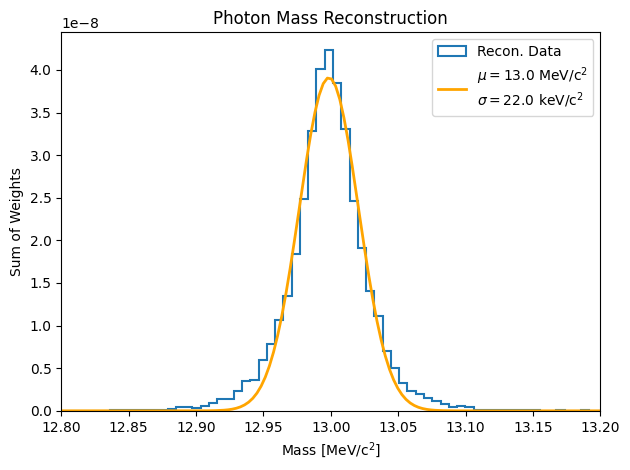

In [51]:
# range_min, range_max = 12.90, 13.10
range_min, range_max = min(res), max(res)

mass_hist, bin_edges = np.histogram(res, weights=w, bins=500, range=[range_min, range_max])
bin_centres = (bin_edges[:-1] + bin_edges[1:]) / 2

initial_guess = [max(mass_hist), np.mean(res), np.std(res)] # initial guess
coeff, var_matrix = optimize.curve_fit(gauss, bin_centres, mass_hist, p0=initial_guess) # fit the gaussian
A_fit, mu_fit, sigma_fit = coeff # extract the params

x_fit = np.linspace(range_min, range_max, 1000)
y_fit = gauss(x_fit, A_fit, mu_fit, sigma_fit)

plt.hist(res, weights=w, bins=bin_edges, range=[range_min, range_max], histtype='step', linewidth=1.5, density=False, label="Recon. Data")
# plt.plot(x_fit, y_fit, label=f"Gaussian Fit:\n$\\mu={mu_fit:.4f}$ MeV/c$^2$, \n$\\sigma={sigma_fit*1000:.4f}$ keV/c$^2$", color='orange', linewidth=2)
plt.plot(x_fit, y_fit, label=f"$\\mu={mu_fit:.1f}$ MeV/c$^2$\n$\\sigma={sigma_fit*1000:.1f}$ keV/c$^2$", color='orange', linewidth=2)

plt.ylabel("Sum of Weights")
plt.title("Photon Mass Reconstruction")
plt.xlabel("Mass [MeV/c$^2$]")
plt.xlim(12.8, 13.2)
plt.savefig("mass_recon", dpi=300)
plt.legend()
plt.tight_layout()
plt.savefig("mass_recon.pdf", dpi=300)
plt.show()

In [15]:
lower_cutoff = 12.90
upper_cutoff = 13.10
outside_cutoff = (len(res[res<lower_cutoff]) + len(res[res>upper_cutoff]))

print(f"Lower Cutoff: {lower_cutoff},\nUpper Cutoff: {upper_cutoff}\n")
print(f"Outside the cutoff: {outside_cutoff} => {outside_cutoff/len(res)*100}% data points!")

Lower Cutoff: 12.9,
Upper Cutoff: 13.1

Outside the cutoff: 207 => 1.0605051488293458% data points!
